# Main

In [167]:
'''
Dependencies
'''
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
import pandas as pd
import scipy.stats as stats
import scipy.sparse as sparse
import warnings 
from scipy import integrate
import seaborn as sns
warnings.simplefilter('ignore')
from sklearn.decomposition import PCA
import scipy.io as sio
import os
from tqdm.auto import tqdm

sns.set_style('white')
# to change default color cycle
cs = ['#616F85', '#C2BAA3', '#F5E6CE', '#DD9D7C', '#C9445F']
csbr = ['#074B6A', '#0A82A4', '#C0E995', '#3F9552', '#F3EE7E', '#E64248', '#E35330']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=csbr)

import pyaldata as pld # using functions from PyalData
import tools # matlab2python functions

In [38]:
sns.__version__

'0.11.1'

### General data info

> In our experiment, we recorded simultaneously from electrode arrays implanted in both M1 and PMd as macaque monkeys learned to make accurate reaching movements that were perturbed (`perturbation`) either by
- curl-field forces (CF) forces
- rotation of visual feedback (VR)

**VR**: Each trial began when the monkey moved to the center target. Each trial began when the monkey moved to the center target. After a variable hold period (0.5 – 1.5 s), one of the eight outer targets appeared. The monkey had a variable instructed delay period (0.5 – 1.5 s) which allowed us to study neural activity during explicit movement planning and preparation, in addition to movement execution. The monkeys then received an auditory go cue, and the center target disappeared. The monkeys had one sec- ond to reach the target, and were required to hold there for 0.5 s.

**CF**: two motors applied torques to the elbow and shoulder joints of the manipulandum in order to achieve the desired endpoint force.

> Each experimental session consisted of three behavioral epochs (`epoch`), each beginning with reaches with no perturbation (baseline epoch) before the monkeys were exposed to a perturbation: either the CF (force epoch) or the VR (rotation epoch).

## 0 Load data and convert to pandas dataframe

The original data is in the form of `.mat` files. Pandas makes it very easy to work with the data. The entire dataset is a set of sessions $S$ of $T$ trials and each trial has $F$ features. The dataset is of the form
\begin{align}
    S \times T \times F
\end{align}

We will do the analysis for one session to begin with, yielding a $T \times F$ matrix.

In [99]:
'''
Insert path and filename 
'''
path = '/Users/Daphne/Data/'  
fname = 'Chewie_CO_VR_2016-10-06.mat' 
df = pld.mat2dataframe(path+fname, shift_idx_fields=True)

In [100]:
df.shape # T x F

(774, 24)

In [101]:
df.head()

,monkey,date,task,target_direction,trial_id,result,bin_size,perturbation,perturbation_info,epoch,...,idx_peak_speed,idx_trial_end,pos,vel,acc,force,M1_spikes,M1_unit_guide,PMd_spikes,PMd_unit_guide
0,Chewie,10-06-2016,CO,-2.356194,1,R,0.01,VR,-0.52,BL,...,363,436,"[[-5.399950889827338, -25.11058978269873], [-5...","[[4.615264447089089, -3.6781866137904946], [4....","[[34.913180411358354, -17.92603186704403], [13...","[[0.3854857746577438, -0.18448026169727955], [...","[[0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,...","[[5, 1], [5, 2], [5, 3], [5, 4], [9, 1], [9, 2...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1], [1, 2], [2, 1], [2, 2], [3, 1], [3, 2..."
1,Chewie,10-06-2016,CO,1.570796,2,R,0.01,VR,-0.52,BL,...,356,447,"[[-5.194667657852522, -35.190944353130526], [-...","[[2.3921738136280783, 2.833707639241631], [2.7...","[[31.99226756476989, 80.42711312188004], [34.1...","[[0.1778157378731141, 0.12542049016429982], [0...","[[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,...","[[5, 1], [5, 2], [5, 3], [5, 4], [9, 1], [9, 2...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1], [1, 2], [2, 1], [2, 2], [3, 1], [3, 2..."
2,Chewie,10-06-2016,CO,0.785398,3,R,0.01,VR,-0.52,BL,...,414,483,"[[0.35267826312911055, -22.923278550949004], [...","[[0.5017102009485903, -3.146994710197926], [0....","[[-7.180978950112355, -35.21789901845524], [3....","[[0.2833417683274762, -0.1285513884878812], [0...","[[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...","[[5, 1], [5, 2], [5, 3], [5, 4], [9, 1], [9, 2...","[[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1], [1, 2], [2, 1], [2, 2], [3, 1], [3, 2..."
3,Chewie,10-06-2016,CO,3.141593,4,R,0.01,VR,-0.52,BL,...,397,458,"[[5.072834875801728, -24.89410841851521], [5.0...","[[-1.3275097541588876, -3.5308863978243985], [...","[[-6.932033881542791, 0.17982626642873387], [-...","[[0.08675043530985374, 0.03658922221440793], [...","[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[5, 1], [5, 2], [5, 3], [5, 4], [9, 1], [9, 2...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1], [1, 2], [2, 1], [2, 2], [3, 1], [3, 2..."
4,Chewie,10-06-2016,CO,-1.570796,5,R,0.01,VR,-0.52,BL,...,301,362,"[[-8.194254800472459, -30.26359832666607], [-8...","[[1.8501123719868446, 0.8394848146862552], [2....","[[48.123169514922175, -9.081942493745938], [58...","[[0.2054977133197953, -0.12485484173352068], [...","[[0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,...","[[5, 1], [5, 2], [5, 3], [5, 4], [9, 1], [9, 2...","[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1], [1, 2], [2, 1], [2, 2], [3, 1], [3, 2..."


### Plot a few hand trajectories

- Baseline epoch (range across sessions: 170 – 225 rewards)
- Force epoch with the CF perturbations (201 – 337 rewards)
- Washout epoch, in which the perturbation was removed and the monkeys readapted to making normal reaches (153 – 404 rewards)

In [159]:
df['pos'][0].shape # number of observations x (x,y) coordinates

(447, 2)

In [160]:
df['epoch'].unique()

array(['BL', 'AD', 'WO'], dtype=object)

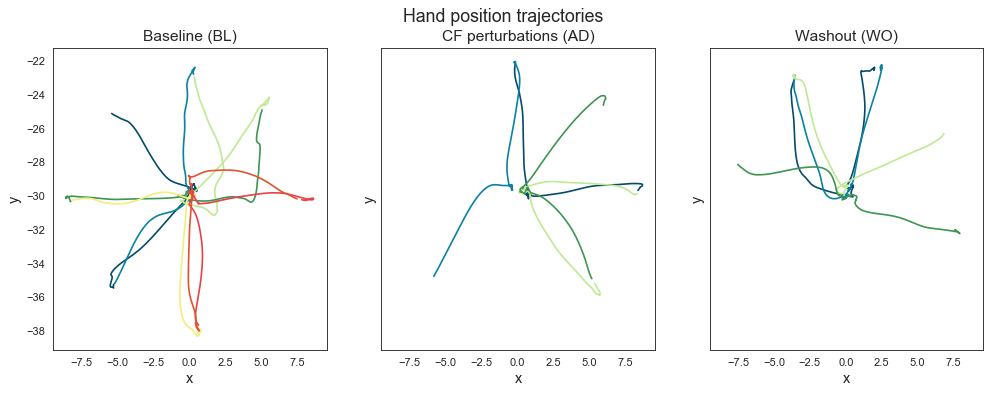

In [168]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5), dpi=80, sharex=True, sharey=True, )
fig.suptitle('Hand position trajectories', fontsize=16)
for i in [0, 1, 2, 3, 4, 5, 6]: ax1.plot(df['pos'][i][:, 0], df['pos'][i][:, 1])
ax1.set_title('Baseline (BL)', fontsize=14)
ax1.set_xlabel('x', fontsize=13)
ax1.set_ylabel('y', fontsize=13)
    
for i in [100, 123, 144, 145]: ax2.plot(df['pos'][i][:, 0], df['pos'][i][:, 1]);
ax2.set_title('CF perturbations (AD)', fontsize=14)
ax2.set_xlabel('x', fontsize=13)
ax2.set_ylabel('y', fontsize=13);
    
for i in [350, 380, 400, 420]: ax3.plot(df['pos'][i][:, 0], df['pos'][i][:, 1]);
ax3.set_title('Washout (WO)', fontsize=14)
ax3.set_xlabel('x', fontsize=13)
ax3.set_ylabel('y', fontsize=13);

In [158]:
df['vel'][0].shape

(447, 2)

In [119]:
df.columns

Index(['monkey', 'date', 'task', 'target_direction', 'trial_id', 'result',
       'bin_size', 'perturbation', 'perturbation_info', 'epoch',
       'idx_trial_start', 'idx_target_on', 'idx_go_cue', 'idx_movement_on',
       'idx_peak_speed', 'idx_trial_end', 'pos', 'vel', 'acc', 'force',
       'M1_spikes', 'M1_unit_guide', 'PMd_spikes', 'PMd_unit_guide'],
      dtype='object')

In [43]:
df.trial_id

0        1
1        2
2        3
3        4
4        5
      ... 
769    340
770    341
771    342
772    343
773    344
Name: trial_id, Length: 774, dtype: int64

In [44]:
df.monkey.unique()

array(['Chewie'], dtype=object)

## 1 Preprocess 

Following the parameters and workflow from `compare_weights_spatially.m`

### 1.1 Combine time bins

Combine time bins into larger ones, here 

In [45]:
td = pld.combine_time_bins(df, n_bins=3)

In [46]:
# print(f'before \n {df.head().bin_size} \n')
# print(f'after combining time bins \n {td.head().bin_size}')

### 1.2 Remove low firing neurons

In [47]:
df.M1_spikes[0]

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 1, 0, 0]], dtype=uint8)

In [48]:
td = pld.remove_low_firing_neurons(td, signal='M1_spikes', threshold=5)
td = pld.remove_low_firing_neurons(td, signal='PMd_spikes', threshold=5)

print(f'original M1 spikes: {df.M1_spikes[0].shape}')
print(f'after removing low firing neurons: {td.M1_spikes[0].shape} \n')

print(f'original PMd spikes: {df.PMd_spikes[0].shape}')
print(f'after removing low firing neurons: {td.PMd_spikes[0].shape}')

original M1 spikes: (447, 63)
after removing low firing neurons: (149, 44) 

original PMd spikes: (447, 192)
after removing low firing neurons: (149, 99)


### 1.3 Transform signals

In [49]:
td = pld.transform_signal(td, signal='M1_spikes',  transformations='sqrt')
td = pld.transform_signal(td, signal='PMd_spikes', transformations='sqrt')

print(td.M1_spikes[0]) # trials x neurons

[[1.         1.         1.         ... 0.         0.         1.        ]
 [0.         1.         0.         ... 0.         1.         0.        ]
 [1.         1.         1.41421356 ... 0.         1.         0.        ]
 ...
 [1.         0.         0.         ... 0.         0.         0.        ]
 [1.         1.         1.41421356 ... 0.         1.         1.        ]
 [0.         1.         0.         ... 0.         1.         0.        ]]


### 1.4 Merge signals from multiple brain areas

Here we add a column `'both_spikes'` to that we can perform PCA on all the neurons

In [50]:
td = pld.merge_signals(td, ['M1_spikes', 'PMd_spikes'], 'both_spikes')

print(f'Merging M1 and PMd gives {td.M1_spikes[0].shape[1]} + {td.PMd_spikes[0].shape[1]} = {td.both_spikes[0].shape[1]} neurons')

Merging M1 and PMd gives 44 + 99 = 143 neurons


In [51]:
td['both_spikes']

0      [[1.0, 1.0, 1.0, 1.4142135623730951, 0.0, 0.0,...
1      [[1.0, 1.0, 0.0, 1.0, 1.0, 1.4142135623730951,...
2      [[1.0, 1.0, 1.4142135623730951, 0.0, 0.0, 1.41...
3      [[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
4      [[0.0, 0.0, 1.0, 1.4142135623730951, 1.0, 1.0,...
                             ...                        
769    [[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0,...
770    [[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
771    [[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.41...
772    [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...
773    [[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0,...
Name: both_spikes, Length: 774, dtype: object

### 1.5 Compute firing rates from spike trains

We convolve the spike trains of each neuron with a non-causal Gaussian kernel to get a smooth firing rate. The columns are added to our dataframe as `'__rates'`.
PCA is performed on these firing rates.

In [52]:
# works on '_spikes' fields and automatically divides by bin_size
td = pld.add_firing_rates(td, 'smooth')

In [53]:
td.head()

,monkey,date,task,target_direction,trial_id,result,bin_size,perturbation,perturbation_info,epoch,...,acc,force,M1_spikes,M1_unit_guide,PMd_spikes,PMd_unit_guide,both_spikes,M1_rates,PMd_rates,both_rates
0,Chewie,10-06-2016,CO,-2.356194,1,R,0.03,VR,-0.52,BL,...,"[[25.292273710326047, 23.948816622289783], [26...","[[0.3854857746577438, -0.18448026169727955], [...","[[1.0, 1.0, 1.0, 1.4142135623730951, 0.0, 0.0,...","[[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...","[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...","[[1, 1], [1, 2], [7, 4], [7, 5], [8, 2], [8, 3...","[[1.0, 1.0, 1.0, 1.4142135623730951, 0.0, 0.0,...","[[10.371933240023875, 15.773752026832693, 12.3...","[[8.902097383481504, 8.635500399091704, 6.2947...","[[10.371933240023875, 15.773752026832693, 12.3..."
1,Chewie,10-06-2016,CO,1.570796,2,R,0.03,VR,-0.52,BL,...,"[[33.67115720999763, 79.08430607100303], [23.7...","[[0.1778157378731141, 0.12542049016429982], [0...","[[1.0, 1.0, 0.0, 1.0, 1.0, 1.4142135623730951,...","[[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...","[[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.414213562373...","[[1, 1], [1, 2], [7, 4], [7, 5], [8, 2], [8, 3...","[[1.0, 1.0, 0.0, 1.0, 1.0, 1.4142135623730951,...","[[11.264847879857852, 14.03731918590052, 8.031...","[[5.401818786808815, 14.407176539761242, 13.14...","[[11.264847879857852, 14.03731918590052, 8.031..."
2,Chewie,10-06-2016,CO,0.785398,3,R,0.03,VR,-0.52,BL,...,"[[1.6623846773446733, -20.151668914256682], [4...","[[0.2833417683274762, -0.1285513884878812], [0...","[[1.0, 1.0, 1.4142135623730951, 0.0, 0.0, 1.41...","[[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...","[[1.0, 1.4142135623730951, 1.0, 0.0, 0.0, 0.0,...","[[1, 1], [1, 2], [7, 4], [7, 5], [8, 2], [8, 3...","[[1.0, 1.0, 1.4142135623730951, 0.0, 0.0, 1.41...","[[10.371933240023875, 16.66666666666667, 11.84...","[[16.66666666666667, 10.949669788579067, 7.742...","[[10.371933240023875, 16.66666666666667, 11.84..."
3,Chewie,10-06-2016,CO,3.141593,4,R,0.03,VR,-0.52,BL,...,"[[-10.229040288523265, -22.654816986306813], [...","[[0.08675043530985374, 0.03658922221440793], [...","[[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...","[[0.0, 1.0, 0.0, 0.0, 0.0, 1.4142135623730951,...","[[1, 1], [1, 2], [7, 4], [7, 5], [8, 2], [8, 3...","[[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.8929146398339769, 8.635500399091704, 10.26...","[[0.8929146398339769, 7.742585759257727, 5.401...","[[0.8929146398339769, 8.635500399091704, 10.26..."
4,Chewie,10-06-2016,CO,-1.570796,5,R,0.03,VR,-0.52,BL,...,"[[55.86100520057167, -6.586410543949703], [45....","[[0.2054977133197953, -0.12485484173352068], [...","[[0.0, 0.0, 1.0, 1.4142135623730951, 1.0, 1.0,...","[[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...","[[1.0, 1.0, 0.0, 1.4142135623730951, 0.0, 0.0,...","[[1, 1], [1, 2], [7, 4], [7, 5], [8, 2], [8, 3...","[[0.0, 0.0, 1.0, 1.4142135623730951, 1.0, 1.0,...","[[8.031166267574964, 8.924080907408943, 13.144...","[[15.773752026832693, 16.66666666666667, 0.892...","[[8.031166267574964, 8.924080907408943, 13.144..."


In [54]:
td.both_rates

0      [[10.371933240023875, 15.773752026832693, 12.3...
1      [[11.264847879857852, 14.03731918590052, 8.031...
2      [[10.371933240023875, 16.66666666666667, 11.84...
3      [[0.8929146398339769, 8.635500399091704, 10.26...
4      [[8.031166267574964, 8.924080907408943, 13.144...
                             ...                        
769    [[0.8929146398339769, 9.005357752952426, 0.0, ...
770    [[6.294733426642792, 8.924080907408943, 0.8929...
771    [[14.407176539761242, 9.120277654299834, 7.742...
772    [[0.8929146398339769, 10.371933240023875, 0.0,...
773    [[10.371933240023875, 16.66666666666667, 8.635...
Name: both_rates, Length: 774, dtype: object

### 1.6 Select a time interval

Perhaps we want to take spikes from a certain interval (this is optional). 

In [ ]:
# examples
plan_td = pld.restrict_to_interval(td, start_point_name='idx_target_on', end_point_name='idx_go_cue', before=0, after=40)

move_td = pld.restrict_to_interval(td, start_point_name='idx_go_cue', end_point_name='idx_trial_end', before=0, after=40)

In [ ]:
#plan_td.head()

In [ ]:
# print(f'Total trial length: {td.both_spikes[0].shape}')

# print(f'Plan trial length: {plan_td.both_spikes[0].shape}')

# print(f'Move trial length: {move_td.both_spikes[0].shape}')

In [ ]:
td.epoch 

## 2 Dimensionality reduction

 > PCA finds the dominant covariation patterns in the population and provides a set of orthogonal basis vectors that capture the population variance. We call these covariance patterns ‘‘latent activity.’’ Importantly, this latent activity reflected the firing of nearly all individual neurons (Perich et al., 2018).
 
We want to perform dimensionality reduction on different subsets;

- Do PCA on all the data together (both the M1 neurons and the PMd neurons) $\rightarrow$ `'both_spikes'`
- Do PCA on the M1 neurons only $\rightarrow$ `'M1_spikes'`
- Do PCA on the PMd neurons only $\rightarrow$ `'PMd_spikes'`


`.components_` is the set of all eigenvectors (aka loadings) for your projection space (one eigenvector for each principal component)

Now we have the firing rates for all the neurons in the M1 and PMd combined:

In [ ]:
print(f'Number of trials: {td.both_rates.shape}')
print(f'Each trial has {td.both_rates[0].shape[0]} observations x {td.both_rates[0].shape[1]} neurons ')

In [ ]:
td['M1_rates']

In [ ]:
# concatenate the rates from different trials in time
rates_m1pmd = np.concatenate(td['both_rates'].values, axis=0)
rates_m1 = np.concatenate(td['M1_rates'].values, axis=0)
rates_pmd = np.concatenate(td['PMd_rates'].values, axis=0)

print(rates_m1pmd.shape) # observations x neurons
print(rates_m1.shape)
print(rates_pmd.shape)

### 2.1 PCA on all neurons

In [55]:
model_m1pmd = PCA()
transformed_vals = pd.DataFrame(model_m1pmd.fit_transform(rates_m1pmd))

# principal component weights 
pca_loadings_m1pmd = pd.DataFrame(model_m1pmd.components_)
#pca_loadings_m1pmd.head() # each row contains the weigths or loadings of one PC

variance_exp_cumsum_m1pmd = model_m1pmd.explained_variance_ratio_.cumsum().round(2)

model_m1pmd.explained_variance_ratio_[:15]

array([0.09973066, 0.0656885 , 0.05272952, 0.03491168, 0.02533259,
       0.02412623, 0.01975881, 0.01768813, 0.01624798, 0.01557538,
       0.01489181, 0.01397789, 0.01277519, 0.01210356, 0.01144775])

PC1 contributed 10%, PC2 contributed 6.6% and so on.

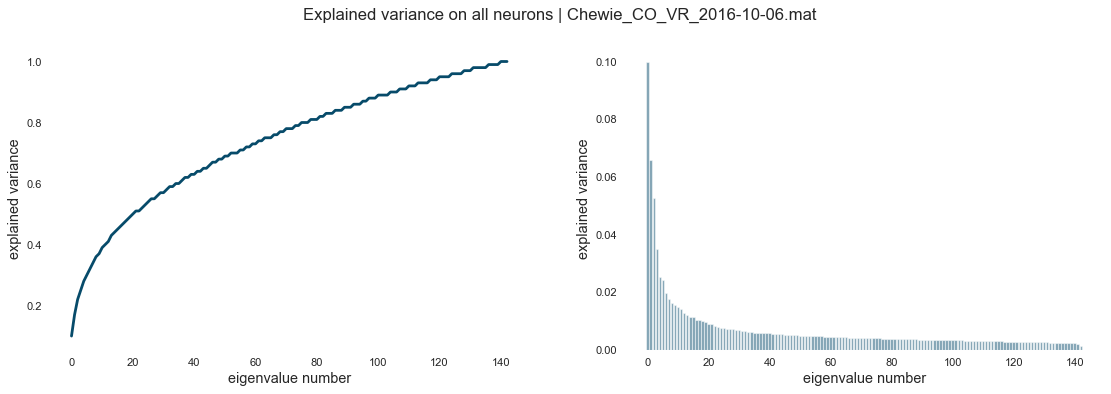

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5), dpi=80)
fig.suptitle(f'Explained variance on all neurons | {fname}', fontsize=15)
ax1.plot(variance_exp_cumsum_m1pmd, lw=2.5)
ax1.set_xlabel('eigenvalue number', fontsize=13)
ax1.set_ylabel('explained variance', fontsize=13)

ax2.bar(range(0, len(model_m1pmd.explained_variance_ratio_)), model_m1pmd.explained_variance_ratio_, alpha=0.5, align='center')
ax2.set_xlabel('eigenvalue number', fontsize=13)
ax2.set_ylabel('explained variance', fontsize=13)
sns.despine(left=True, bottom=True);

In [57]:
model_m1pmd.components_

array([[-0.09257895, -0.04976282, -0.09884685, ..., -0.0033796 ,
         0.24612069, -0.07991114],
       [-0.11525689, -0.16789862, -0.17755237, ...,  0.01195134,
         0.18383936, -0.00826234],
       [ 0.18250418,  0.20102647,  0.13952209, ...,  0.04255159,
         0.16208462, -0.07781298],
       ...,
       [ 0.0860489 , -0.08272472, -0.0368433 , ..., -0.03924823,
        -0.00968876, -0.00182384],
       [ 0.72116723, -0.47028311,  0.00754136, ..., -0.01730903,
         0.01135002,  0.01201014],
       [-0.00757641,  0.00552947,  0.0017994 , ...,  0.00575537,
        -0.00448501,  0.00735529]])

The singular values corresponding to each of the selected components. The singular values are equal to the 2-norms of the n_components variables in the lower-dimensional space.

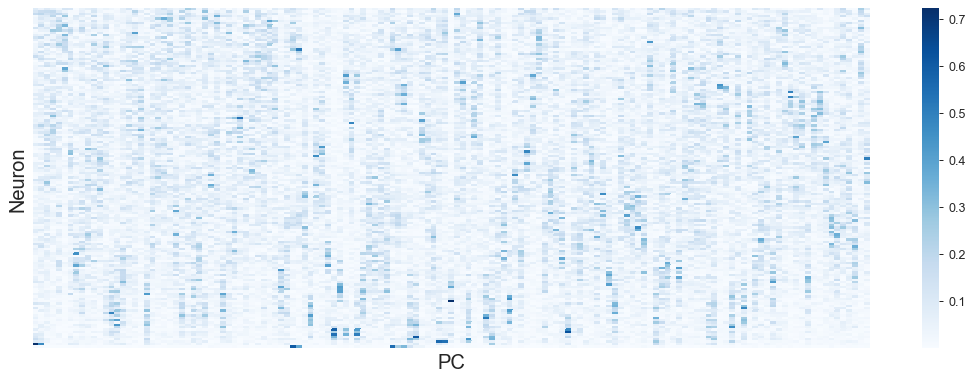

In [58]:
fig, ax = plt.subplots(1, figsize = (15, 5), dpi=90)
ax.set_title('', fontsize=15)
sns.heatmap(np.abs(model_m1pmd.components_), cmap='Blues', ax=ax, xticklabels=False, yticklabels=False);
ax.set_xlabel('PC', fontsize=16) 
ax.set_ylabel('Neuron', fontsize=16);

### 2.2 PCA on M1 neurons

In [59]:
model_m1 = PCA()
transformed_vals = pd.DataFrame(model_m1.fit_transform(rates_m1))

# principal component weights 
pca_loadings_m1 = pd.DataFrame(model_m1.components_)
variance_exp_cumsum_m1 = model_m1.explained_variance_ratio_.cumsum().round(2)

model_m1.explained_variance_ratio_[:15]

array([0.12331053, 0.09966624, 0.08789667, 0.05502105, 0.04286803,
       0.04042454, 0.03572576, 0.03503671, 0.02701463, 0.02658214,
       0.02638351, 0.02163223, 0.02141103, 0.01992707, 0.01935312])

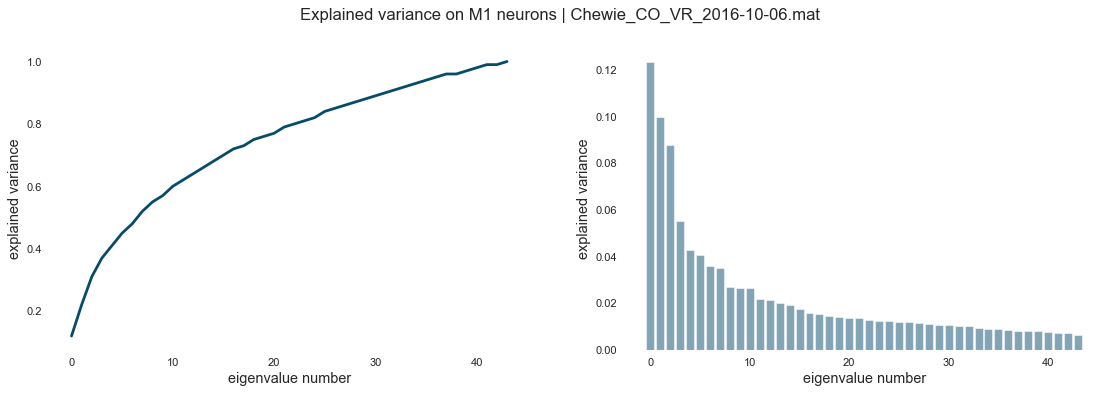

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5), dpi=80)
fig.suptitle(f'Explained variance on M1 neurons | {fname}', fontsize=15)
ax1.plot(variance_exp_cumsum_m1, lw=2.5)
ax1.set_xlabel('eigenvalue number', fontsize=13)
ax1.set_ylabel('explained variance', fontsize=13)

ax2.bar(range(0, len(model_m1.explained_variance_ratio_)), model_m1.explained_variance_ratio_, alpha=0.5, align='center')
ax2.set_xlabel('eigenvalue number', fontsize=13)
ax2.set_ylabel('explained variance', fontsize=13)
sns.despine(left=True, bottom=True);

### 2.3 PCA on PMd neurons

In [61]:
model_pmd = PCA()
transformed_vals = pd.DataFrame(model_pmd.fit_transform(rates_pmd))

# principal component weights 
pca_loadings_pmd = pd.DataFrame(model_pmd.components_)
variance_exp_cumsum_pmd = model_pmd.explained_variance_ratio_.cumsum().round(2)

model_pmd.explained_variance_ratio_[:15]

array([0.11224548, 0.07278479, 0.04256417, 0.0345311 , 0.02605734,
       0.02308141, 0.02107253, 0.02006923, 0.01768764, 0.01743519,
       0.0168857 , 0.01526974, 0.01454986, 0.01411731, 0.01351465])

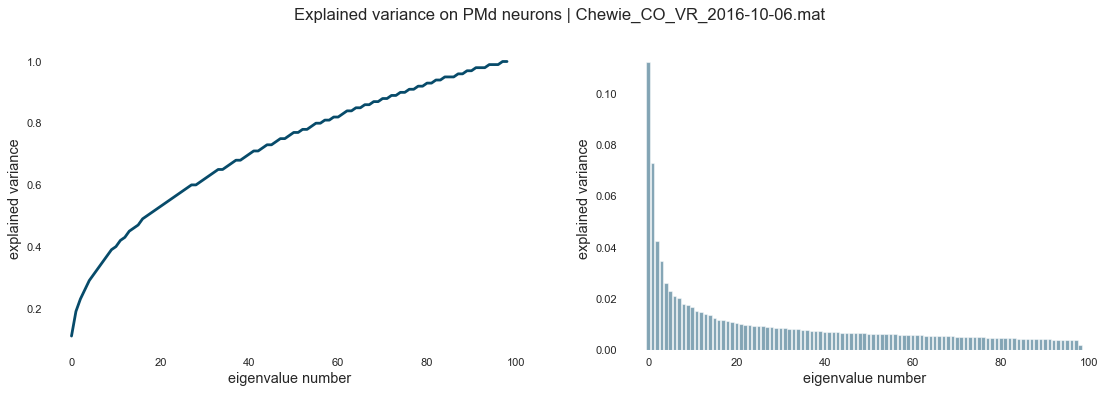

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5), dpi=80)
fig.suptitle(f'Explained variance on PMd neurons | {fname}', fontsize=15)
ax1.plot(variance_exp_cumsum_pmd, lw=2.5)
ax1.set_xlabel('eigenvalue number', fontsize=13)
ax1.set_ylabel('explained variance', fontsize=13)

ax2.bar(range(0, len(model_pmd.explained_variance_ratio_)), model_pmd.explained_variance_ratio_, alpha=0.5, align='center')
ax2.set_xlabel('eigenvalue number', fontsize=13)
ax2.set_ylabel('explained variance', fontsize=13)
sns.despine(left=True, bottom=True);

### 2.4 Global and self manifold

- We did PCA on the M1 and PMd neurons separately and together
- Let's take the first PC and correlate that with the combined PC
- How similar of a dimension do you find when performing dimensionality reduction on these firing rates when taken alone vs. when taking them together?

> **Global manifold** PMd + M1 together

> **Self manifold** PMd or M1

``

In [ ]:
# of the form n_components x n_features, take the first row

first_pc_m1pmd = model_m1pmd.components_[0, : ]

print(first_pc_m1pmd.shape)

first_pc_m1 = model_m1.components_[0, : ]

first_pc_pmd = model_pmd.components_[0, : ]

In [ ]:
model_m1pmd.components_.shape # how can I correlate arrays of a different shape??

In [44]:
model_m1.components_.shape

(44, 44)

In [45]:
model_pmd.components_.shape

(99, 99)

## 3. Robust Principal Component analysis

- PCA is sensitive to outliers and corrupted data
- Robust PCA (RPCA) wants to decompose a data matrix $X$ into a structured low-rank matrix $L$ and a sparse matrix $S$ that contains the outliers and corrupted data
\begin{align}
    X = L + S
\end{align}
- The principal components $L$ are robust to the outliers and corrupted data in $S$
- Goal is to find $L, S$ that satisfy the following minimisation function
\begin{align}
    \underset{L, S}{\text{min}} \| L \|_* + \lambda \| S \|_1 
\end{align}
subject to $L+S=X$.
Here we use $\| . \|_*$ to denote the nuclear norm (a proxy for rank).


---

Steve Brunton (2021) Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control - Chapter 3



In [ ]:
'''
Check if matrix is sparse (will it converge)
'''

scipy.sparse.issparse(rates_m1pmd)

In [ ]:
'''
RPCA
'''

# ASK: RPCA relevance

def shrink(X,tau):
    Y = np.abs(X)-tau
    return np.sign(X) * np.maximum(Y,np.zeros_like(Y))

def SVT(X,tau):
    U,S,VT = np.linalg.svd(X,full_matrices=0)
    out = U @ np.diag(shrink(S,tau)) @ VT
    return out

def RPCA(X):
    n1,n2 = X.shape
    mu = n1*n2/(4*np.sum(np.abs(X.reshape(-1))))
    lambd = 1/np.sqrt(np.maximum(n1,n2))
    thresh = 10**(-7) * np.linalg.norm(X)
    
    S = np.zeros_like(X)
    Y = np.zeros_like(X)
    L = np.zeros_like(X)
    count = 0
    while (np.linalg.norm(X-L-S) > thresh) and (count < 1000):
        L = SVT(X-S+(1/mu)*Y,1/mu)
        S = shrink(X-L+(1/mu)*Y,lambd/mu)
        Y = Y + mu*(X-L-S)
        count += 1
    return L,S

In [ ]:
# X = rates_m1pmd
# L,S = RPCA(X)

## 4 Compare PCAs Spatially

- Is there a relationship between similarity in spiking patterns and spatial distance? This is a good dataset to investigate that because we have data from M1 and PMd.
- How different is the weight found on the first PC for various distances?
- There are 3 types of distance to consider:
    - 1. On one electrode we have $n$ neurons. How similar are the neurons on the same electrode?
    - 2. Compare the neurons on different electorodes, but on the same array [within array PMd and M1]
    - 3. Compare the neurons on different electrodes and different arrays [M1 -> PMd, PMd -> M1]
- Prediction: inverse relationship between distance and similarity

In [63]:
'''
The unit guides specify how many cells each electrode measures (I think, ASK)

[Electrode number, # cells that electrode covers]
'''

td['M1_unit_guide'] 

0      [[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...
1      [[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...
2      [[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...
3      [[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...
4      [[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...
                             ...                        
769    [[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...
770    [[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...
771    [[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...
772    [[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...
773    [[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...
Name: M1_unit_guide, Length: 774, dtype: object

In [64]:
td['PMd_unit_guide'].shape[0]

774

In [82]:
num_cells_elec_m1 = []
num_cells_elec_pmd = []

for i in range(td['M1_unit_guide'].shape[0]):
    num_cells_elec_m1.append(td['M1_unit_guide'][i][:, 1])
    num_cells_elec_pmd.append(td['PMd_unit_guide'][i][:, 1])
    
num_cells_elec_m1 = np.concatenate(num_cells_elec_m1, axis=0)
num_cells_elec_pmd = np.concatenate(num_cells_elec_pmd, axis=0)

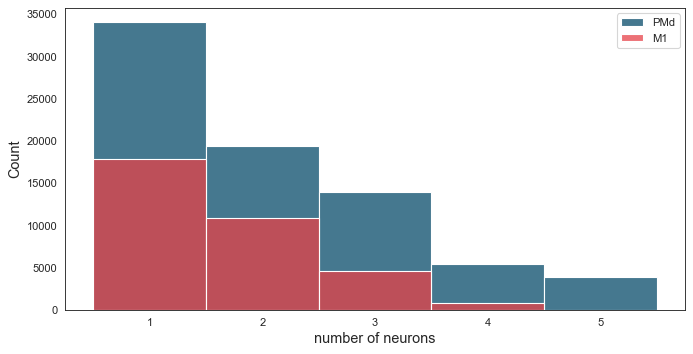

In [96]:
fig, ax = plt.subplots(1, figsize=(10,5), dpi=80)
fig.suptitle('', fontsize=14)
sns.histplot(data=num_cells_elec_pmd, ax=ax, discrete=True, label='PMd')
sns.histplot(data=num_cells_elec_m1, ax=ax, discrete=True, label='M1', color=csbr[4])
ax.set_xlabel('number of neurons', fontsize=13)
ax.set_ylabel('Count', fontsize=13)
ax.legend();

In [93]:
td['M1_unit_guide'][0].max() # this should be the electrode number

95

In [94]:
td['M1_unit_guide'][0].shape

(44, 2)

In [95]:
td['PMd_unit_guide'][0].shape

(99, 2)

In [ ]:
#td['M1_unit_guide'][0] # ASK - L: electrode number & R: number of neurons

In [ ]:
'''
Find out which cell belongs to which electrode
'''

elecs = np.arange(0, 95)

# make arrays to store cells in elecs
m1_units = np.zeros(len(elecs))
pmd_units = np.zeros(len(elecs))

for i in range(len(elecs)):
    # m1
    m1_units[i] = np.where() # store indices that belong to a certain electrode
    # pmd
    

In [ ]:
td['M1_unit_guide'][0][:, 0]

In [ ]:
np.where()

In [ ]:
# % find list of cells on each electrode
# elecs = 1:96;
# [m1_units,pmd_units] = deal(cell(length(elecs),2));
# for i = 1:length(elecs)
#     % M1
#     m1_units{i,2} = find(td(1).M1_unit_guide(:,1) == elecs(i));
#     % PMd
#     pmd_units{i,2} = find(td(1).PMd_unit_guide(:,1) == elecs(i));
# end

# % get spatial location of each electrode
# elec_map = read_cmp('/Users/mattperich/Dropbox/Research/Data/Chewie/Chewie Left M1 SN 6250-001474.cmp');
# for i = 1:length(elecs)
#     idx = find(cellfun(@(x) x == elecs(i),elec_map(:,3)));
#     m1_units{i,1} = [elec_map{idx,1},elec_map{idx,2}];
# end

# elec_map = read_cmp('/Users/mattperich/Dropbox/Research/Data/Chewie/Chewie Left PMd SN 6251-001469.cmp');
# for i = 1:length(elecs)
#     idx = find(cellfun(@(x) x == elecs(i),elec_map(:,3)));
#     pmd_units{i,1} = [elec_map{idx,1},elec_map{idx,2}];
# end

# Notes

### Singular Value Decomposition

> $A = USV^T$

- SVD separates any matrix $A$ into rank one pieces
- SVD factors $A$ into $USV^T = u_1 \sigma_1 v_1^T, \dots , u_r \sigma_r v_r^T$, with $r$ singular values that are ordered in terms of importance $\sigma_1 \geq \dots \geq \sigma_r \geq 0$
- The numbers $\sigma_1^2, \dots , \sigma_r^2$ are the nonzero eigenvalues of $AA^T$ and $A^TA$
- The orthonormal columns of $U$ and $V$ are the eigenvectors of $AA^T$ and $A^TA$: they make an orthonormal basis for the four fundamental subspaces of $A$
   - $Av_i = \sigma_i u_i$
- Only if $A$ is a positive (semi) definite symmetric matrix we have that $A = USV^T$ (the singular values) are the same as $X \Lambda X^{-1}$ (the eigenvalues of $A$)

### Principal Component Analysis

> Emphasizes variation and bring out the strong patterns in the dataset

- PCA is an application of SVD
- Here, we have a data matrix $A$ of $m$ *measurements* (the neurons from which is recorded) and $n$ *samples* (timepoints) [e.g. 143 neurons x 100575 timepoints]
- Center each row of $A$ by subtracting the mean from each measurement
- The SVD finds combinations of the data that contains the most information
- The singular values and singular vectors of $A$ come from the eigenvalues $\lambda = \sigma^2$ and the eigenvectors $u$ of the sample covariance matrix $S = AA^T/(n-1)$ 
- The total variance (T) in the data is the sum of all the eigenvalues and sample variances $s^2$
\begin{align}
    T = \sigma_1^2 + \dots + \sigma_m^2 = s_1^2 + \dots + s_m^2 = \text{trace}
\end{align}
- The first eigenvector $u_1$ of $S$ points in the most significant direction of the data. That direction explains most of the variance in the data: it explains a fraction of $\sigma_1^2 / T$ of the total variance.
- The next eigenvector $u_2$ (which is orthogonal to $u_1$) explains a smaller fraction of the variance $\sigma_2^2 / T$
- The idea is to stop when these fractions get really small, we now have $R$ directions that explain most of the data. The $n$ data points are close to an $R$-dimensional subspace with basis $u_1$ to $u_R$. These $u$'s are the **principal components** in $m$-dimensional space.  

--- 

Gilbert Strang (2016): Chapter 7 [SVD] 


## Principal component weights

> Motivation

We perform dimensionality reduction on the data to find a lower dimensional Manifold. Not much attention is payed to the lower principal components, while this could be interesting as well. Let's say we have the following decomposition of the spike trains
<!-- 
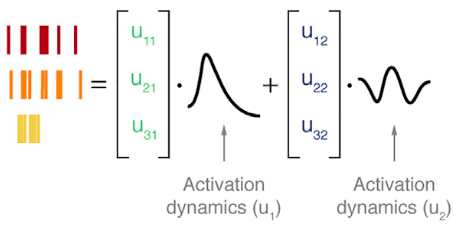
 -->
where $u_1 = [u_{11}, u_{21}, u_{31}]$ and $u_2 = [u_{12}, u_{22}, u_{32}]$ are the weight vectors. These weight vectors in themselves can also be informative because they tell us what the loading of each of the dimensions - for each neuron - is.

We would like to understand if there is a relationship (correlation) between the weight vectors and the spatial location in the brain. 

TODO

- Look at the weights
- Look at the median
- Look at the quantiles
- Look at the KL divergence
- Check if the data is sparse